### Домашнее задание
1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.
2. *Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).
3. *Оптимизировать код для KNN (оставить один цикл, либо обойтись без циклов вообще).

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
X_train.shape, X_test.shape

((120, 2), (30, 2))

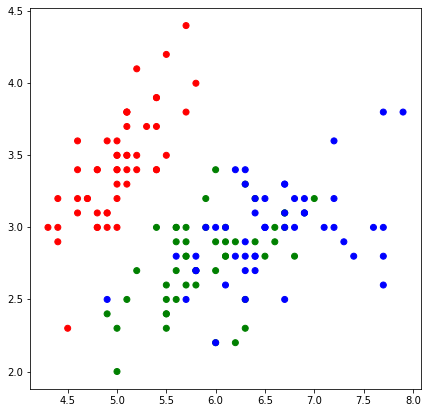

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

In [5]:
def e_metrics(x1, x2):
    
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

In [6]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

In [7]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [8]:
%%time
y_pred = knn(X_train, y_train, X_test, k=4)

Wall time: 65 ms


### Задание1
К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

In [9]:
def knn_weight(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for i, d in enumerate(sorted(test_distances)[0:k]):
            
            #-----------------------------------------------------------------------------------------------
            # В качестве определения веса используем индекс соседа в отсортированной выборке    
            classes[d[1]] += 1/(i+1)
            
            #----------------------------------------------------------------------------------------------
        
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

In [10]:
k = 4
y_pred_weight = knn_weight(X_train, y_train, X_test, k)
y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма без весов при k = {k}: {accuracy(y_pred, y_test):.3f}')
print(f'Точность алгоритма с весами  при k = {k}: {accuracy(y_pred_weight, y_test):.3f}')

Точность алгоритма без весов при k = 4: 0.700
Точность алгоритма с весами  при k = 4: 0.700


### Задание2
*Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [11]:
from sklearn.datasets import make_blobs, make_moons

X, y = make_blobs(n_samples=100, random_state=1)

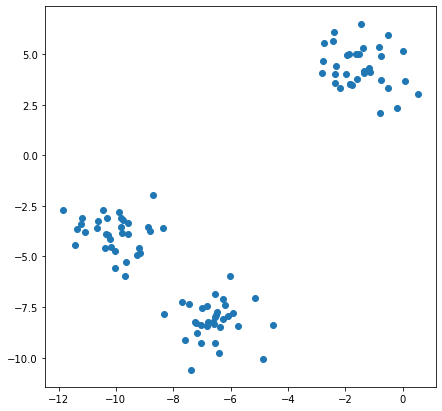

In [12]:
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1]);

In [13]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для кластеризации
    clusters = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # кластеризуем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            cluster = distances.index(min(distances))
            clusters[cluster].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for cluster in clusters:
            centroids[cluster] = np.mean(clusters[cluster], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.linalg.norm(centroids[centroid] - old_centroids[centroid], ord=2) > min_distance:
                optimal = False
                break
        
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, clusters

In [14]:
# определим максимальное количество итераций
max_iterations = 5

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

In [15]:
# Cредне квадратичное внутрикластерное расстояние
def mscd(centroids, clusters):
    dist_clust = {clust :[e_metrics(x, centroids[clust])**2 for x in clusters[clust]] for clust in clusters.keys()}
    k_sum=0
    for k in dist_clust.keys():
        k_sum += np.mean(dist_clust[k])
    return k_sum

In [16]:
res = []
for i in range(1,10):
    centroids, clusters = kmeans(X, i, max_iterations, min_distance=1e-4)
    res.append(mscd(centroids, clusters))

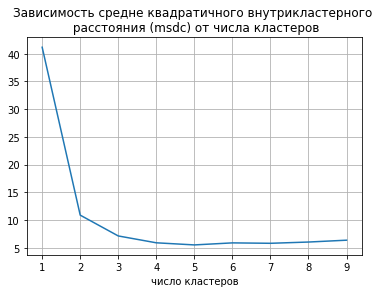

In [17]:
plt.plot(list(range(1,10)),res)
plt.title('Зависимость средне квадратичного внутрикластерного \n расстояния (msdc) от числа кластеров')
plt.xlabel('число кластеров')
plt.grid()
plt.show()

### Задание3
*Оптимизировать код для KNN (оставить один цикл, либо обойтись без циклов вообще).

In [18]:
from statistics import mode

In [19]:
def knn_time(X_train, y_train, X_test, k):
    mx_test = np.repeat(X_test, X_train.shape[0], axis=0).reshape(-1, X_train.shape[0], X_train.shape[1])
    mx_train = np.repeat(X_train, X_test.shape[0], axis=0).reshape(-1, X_test.shape[0], X_train.shape[1])
    mx_train_T = np.transpose(mx_train, (1,0,X_train.shape[1]))
    mx_dist = np.array(np.linalg.norm(mx_test-mx_train_T, ord=2, axis=2))
    index_min = np.argsort(mx_dist)
    classes = y_train[index_min[:,:k]]
    result = np.apply_along_axis(mode, axis=1, arr=classes)
    return result
    

In [20]:
%%time
y_pred = knn(X_train, y_train, X_test, k=4)

Wall time: 69.9 ms


In [21]:
%%time
y_pred_time = knn_time(X_train, y_train, X_test, k=4)

Wall time: 3 ms


In [22]:
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 4: 0.700


In [23]:
print(f'Точность алгоритма оптимизированного по времени исполнения при k = {k}: {accuracy(y_pred_time, y_test):.3f}')

Точность алгоритма оптимизированного по времени исполнения при k = 4: 0.700
